## YOLO + SAM multi

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install ultralytics

In [ ]:
import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/Noha-Magdy/segment-anything.git'

!mkdir images
!wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
!wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/groceries.jpg

!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth


In [ ]:
import os
import torch
import numpy as np
import cv2
from tqdm import tqdm
import nibabel as nib
import matplotlib.image
import random
from ultralytics import YOLO
import matplotlib.pyplot as plt


from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision.transforms import Compose, ToTensor, Resize
from torch.utils.data import Subset

from segment_anything import SamPredictor, sam_model_registry
from segment_anything.utils.transforms import ResizeLongestSide
import torch.nn.functional as F
from skimage import transform, io, segmentation

In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
! unzip "/content/drive/MyDrive/Updated_BraTSData_SSA_only.zip"

In [ ]:
! unzip "ASNR-MICCAI-BraTS2023-SSA-Challenge-ValidationData.zip"

In [ ]:
len(os.listdir("/content/ASNR-MICCAI-BraTS2023-SSA-Challenge-ValidationData"))

15

In [ ]:
# models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


yolo = YOLO('/content/drive/MyDrive/save_to/yolo/t2f_z_2/weights/best.pt')


model_type = 'vit_h'
checkpoint = 'sam_vit_h_4b8939.pth'
sam_model = sam_model_registry[model_type](checkpoint=checkpoint).to(device)

decoder = sam_model.mask_decoder
model_path = "/content/drive/MyDrive/save_to/sam/sam_model_best_multi2.pth"
checkpoint = torch.load(model_path, map_location="cpu")
decoder.load_state_dict(checkpoint)
decoder.to(device)


In [ ]:
def get_yolo_box(image):
  results = yolo.predict(image, stream = False)
  boxes = results[0].boxes

  if len(boxes.xyxy.cpu().numpy()) == 0:
    return [0,0,0,0]

  box = boxes.xyxy[0].cpu().numpy()
  box = [int(i) for i in box]

  return box


# def tranform_mask(mask):
#   res = np.zeros(mask.shape[1:])

#   msk1 = mask[0]
#   msk2 = mask[1]
#   msk3 = mask[2]

#   res[msk1>0] = 1
#   res[msk2>0] = 2
#   res[msk3>0] = 3

#   return res


def tranform_mask(mask):
  res = np.zeros(mask.shape[1:])



  msk3 = mask[2]

  msk2 = mask[1]
  msk2[msk3>0]=0

  msk1 = mask[0]
  msk1[msk2>0]=0
  msk1[msk3>0]=0


  res[msk1>0] = 2
  res[msk2>0] = 3
  res[msk3>0] = 1

  return res



def get_sam_masks(image, bbox):
  if bbox == [0,0,0,0]:
    return np.zeros((240,240))

  box_np = np.array(bbox)
  sam_trans = ResizeLongestSide(sam_model.image_encoder.img_size)
  box = sam_trans.apply_boxes(box_np, (256, 256))
  box_torch = torch.as_tensor(box, dtype=torch.float, device=device)

  sam_transform = ResizeLongestSide(sam_model.image_encoder.img_size)
  image = sam_transform.apply_image(image)
  input_size = (image.shape[0], image.shape[1])
  image = torch.as_tensor(image.transpose(2, 0, 1)).to('cuda')
  image = sam_model.preprocess(image[None,:,:,:]) # (1, 3, 1024, 1024)
  image = image[0,...] # (3, 1024, 1024)

  with torch.no_grad():
    embedding = sam_model.image_encoder(image[None,...])[0]

    sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(points=None, boxes=box_torch, masks=None)

    mask_predictions, _ = decoder(
          image_embeddings= embedding[None,...].to(device), # (B, 256, 64, 64)
          image_pe=sam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
          sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
          dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
          multimask_output=True,
        )
  masks = sam_model.postprocess_masks(mask_predictions, input_size, (240, 240))
  masks = masks > sam_model.mask_threshold
  mask = np.squeeze(masks.cpu().numpy(), axis = 0)
  mask = np.int32(mask)
  mask = tranform_mask(mask)

  return mask

In [ ]:
x = os.listdir((src_folder))[:1][0]
print(x)
image_3d = nib.load("/content/ASNR-MICCAI-BraTS2023-SSA-Challenge-TrainingData_V2/BraTS-SSA-00093-000/BraTS-SSA-00093-000-t2f.nii.gz")
image_3d = image_3d.get_fdata()
# image = image_3d

lower_bound, upper_bound = np.percentile(image_3d, 0.5), np.percentile(image_3d, 99.5)
image_data_pre = np.clip(image_3d, lower_bound, upper_bound)
d = (np.max(image_data_pre)-np.min(image_data_pre))
d = 1 if d==0 else d
image_data_pre = ((image_data_pre - np.min(image_data_pre))/d) *255.0
image_data_pre[image_3d==0] = 0

image_3d = image_data_pre

image = image_3d[:,:,70]
image = transform.resize(image[:,:], (256, 256), order=3, preserve_range=True, mode='constant', anti_aliasing=True)
image = np.uint8(image)
image = np.stack((image, image, image), axis = -1 )

print(image.shape)
bbox = get_yolo_box(image)

# mask = get_sam_masks(image, bbox)
# print(mask.shape)
# print(np.unique(mask))

# plt.imshow(mask, cmap = "gray")



BraTS-SSA-00093-000



0: 256x256 1 cancer, 18.1ms
Speed: 0.8ms preprocess, 18.1ms inference, 2.0ms postprocess per image at shape (1, 3, 256, 256)


(256, 256, 3)


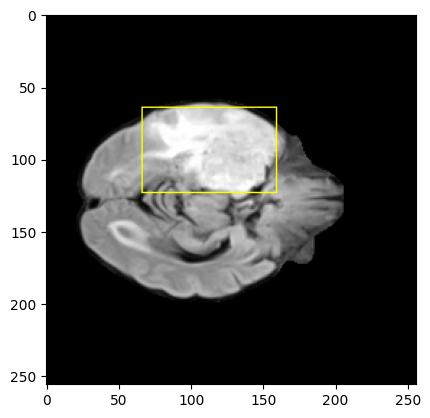

In [ ]:
colour = (255, 255, 0)
thickness = 1
rectangle_img = cv2.rectangle(image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), colour, thickness)
plt.imshow(rectangle_img, cmap="gray")

In [ ]:
src_folder = "/content/ASNR-MICCAI-BraTS2023-SSA-Challenge-ValidationData/"

for i in os.listdir(src_folder):
  image_3d = nib.load(src_folder + i + "/" + i + "-t2f.nii.gz")
  image_3d = image_3d.get_fdata()
  num_slics = image_3d.shape[2]

  output = np.zeros_like(image_3d)

  for s in range(num_slics):
    image = image_3d[:,:,s]

    lower_bound, upper_bound = np.percentile(image, 0.5), np.percentile(image, 99.5)
    image_data_pre = np.clip(image, lower_bound, upper_bound)
    d = (np.max(image_data_pre)-np.min(image_data_pre))
    d = 1 if d==0 else d
    image_data_pre = ((image_data_pre - np.min(image_data_pre))/d) *255.0
    image_data_pre[image==0] = 0
    image = transform.resize(image_data_pre[:,:], (256, 256), order=3, preserve_range=True, mode='constant', anti_aliasing=True)
    image = np.uint8(image)
    image = np.stack((image, image, image), axis = -1 )

    bbox = get_yolo_box(image)

    mask = get_sam_masks(image, bbox)

    output[:,:,s] = mask

  id = i.split("-")[2]
  time = i.split("-")[3]
  ni_img = nib.Nifti1Image(output, affine=np.eye(4))
  nib.save(ni_img, "/content/out/seg-" + id + "-" + time + ".nii.gz" )
  print("-------------------case done ", np.unique(output), "-----------------------")





In [ ]:
! zip -r submission_1.zip /content/out

  adding: content/out/ (stored 0%)
  adding: content/out/seg-00129-000.nii.gz (deflated 100%)
  adding: content/out/seg-00198-000.nii.gz (deflated 82%)
  adding: content/out/seg-00169-000.nii.gz (deflated 83%)
  adding: content/out/seg-00158-000.nii.gz (deflated 96%)
  adding: content/out/seg-00218-000.nii.gz (deflated 97%)
  adding: content/out/seg-00132-000.nii.gz (deflated 81%)
  adding: content/out/seg-00148-000.nii.gz (deflated 85%)
  adding: content/out/seg-00143-000.nii.gz (deflated 84%)
  adding: content/out/seg-00188-000.nii.gz (deflated 94%)
  adding: content/out/seg-00139-000.nii.gz (deflated 86%)
  adding: content/out/seg-00210-000.nii.gz (deflated 88%)
  adding: content/out/seg-00192-000.nii.gz (deflated 94%)
  adding: content/out/seg-00180-000.nii.gz (deflated 98%)
  adding: content/out/seg-00126-000.nii.gz (deflated 91%)
  adding: content/out/seg-00227-000.nii.gz (deflated 99%)


## Testing

In [ ]:

def squarify(M,val = 0):
    (a,b)=M.shape
    if a>b:
        padding=((0,0),(0,a-b))
    else:
        padding=((0,b-a),(0,0))
    return np.pad(M,padding,mode='constant',constant_values=val)

# create_folders
base = "/content/"
os.makedirs(base + "BraTS_data", exist_ok=True)

os.makedirs(base + "BraTS_data/valid/images", exist_ok=True)
os.makedirs(base + "BraTS_data/valid/labels", exist_ok=True)


src_folder = "/content/ASNR-MICCAI-BraTS2023-SSA-Challenge-ValidationData/"

files = os.listdir(src_folder)[2:3]
# files = ["BraTS-SSA-00002-000"]
for i in tqdm(files):
  img =  nib.load(src_folder + i + "/"+ i +"-t2f.nii.gz")
  img = img.get_fdata()

  image_size = 256

  num_slices = img.shape[2]


  for s in range(num_slices):
    image = img[:,:,s]

    path = base + "BraTS_data/valid/images/" +i+ "_"+ str(s)+".tif"

    lower_bound, upper_bound = np.percentile(image, 0.5), np.percentile(image, 99.5)
    image_data_pre = np.clip(image, lower_bound, upper_bound)
    d = (np.max(image_data_pre)-np.min(image_data_pre))
    d = 1 if d==0 else d
    image_data_pre = ((image_data_pre - np.min(image_data_pre))/d) *255.0
    image_data_pre[image==0] = 0
    image = transform.resize(image_data_pre[:,:], (image_size, image_size), order=3, preserve_range=True, mode='constant', anti_aliasing=True)
    # image = np.stack((image, image, image), axis = -1 )
    image = np.uint8(image)
    # image = squarify(image)
    cv2.imwrite(path, image)




In [ ]:
! rm -r "/content/BraTS_data"

In [ ]:
src_folder = "/content/BraTS_data/valid/images/"

model = YOLO('/content/drive/MyDrive/save_to/yolo/t2f_z_2/weights/best.pt')

files = os.listdir(src_folder)
for i in files:
  res = model(src_folder  + i)
  res_plotted = res[0].plot()

  plt.imshow(res_plotted, cmap = "gray")

  plt.show()



Output hidden; open in https://colab.research.google.com to view.

In [ ]:
! unzip "/content/ASNR-MICCAI-BraTS2023-SSA-Challenge-TrainingData.zip"

In [ ]:
image_3d = nib.load("/content/ASNR-MICCAI-BraTS2023-SSA-Challenge-TrainingData_V2/BraTS-SSA-00230-000/BraTS-SSA-00230-000-t2f.nii.gz")
image_3d = image_3d.get_fdata()
num_slics = image_3d.shape[2]

output = np.zeros_like(image_3d)

for s in range(num_slics):
  image = image_3d[:,:,s]

  lower_bound, upper_bound = np.percentile(image, 0.5), np.percentile(image, 99.5)
  image_data_pre = np.clip(image, lower_bound, upper_bound)
  d = (np.max(image_data_pre)-np.min(image_data_pre))
  d = 1 if d==0 else d
  image_data_pre = ((image_data_pre - np.min(image_data_pre))/d) *255.0
  image_data_pre[image==0] = 0
  image = transform.resize(image_data_pre[:,:], (256, 256), order=3, preserve_range=True, mode='constant', anti_aliasing=True)
  image = np.uint8(image)
  image = np.stack((image, image, image), axis = -1 )

  bbox = get_yolo_box(image)

  mask = get_sam_masks(image, bbox)

  output[:,:,s] = mask


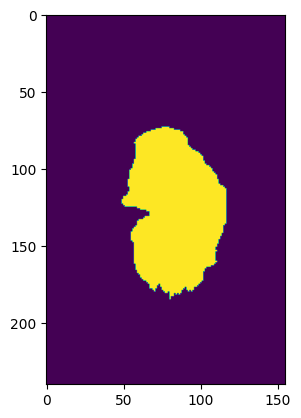

In [ ]:
true = nib.load("/content/ASNR-MICCAI-BraTS2023-SSA-Challenge-TrainingData_V2/BraTS-SSA-00230-000/BraTS-SSA-00230-000-seg.nii.gz")
true = true.get_fdata()
im = true[90,:,:]
im[im>0] = 1
plt.imshow(im)

[          0           1]
[          0           1           2           3]


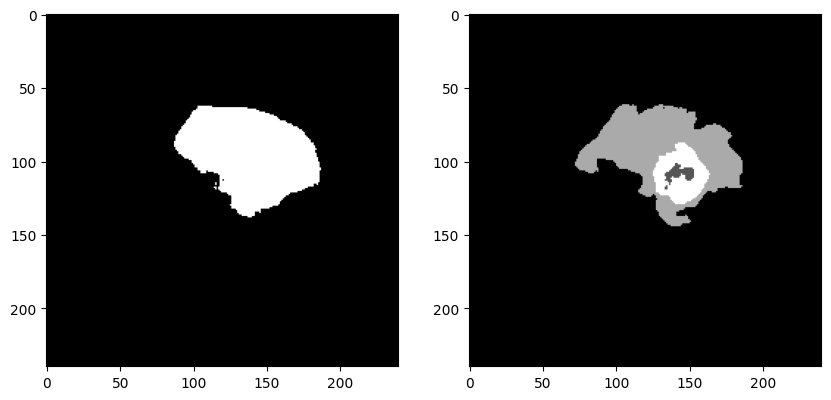

In [ ]:
idx = 90
fig = plt.figure(figsize=(10, 7))

fig.add_subplot(1, 2, 1)
plt.imshow(output[:,:,idx], cmap = "gray")
print(np.unique(output[:,:,idx]))

fig.add_subplot(1, 2, 2)
plt.imshow(true[:,:,idx], cmap = "gray")
print(np.unique(true[:,:,idx]))


plt.show()

In [ ]:
! pip install monai
import monai

In [ ]:
Dice = monai.metrics.DiceMetric(include_background=False, num_classes=3)

y_pred = torch.as_tensor(np.expand_dims(output, axis = 0))
y = torch.as_tensor(np.expand_dims(true, axis = 0))
score = Dice(y, y)
score

torch.Size([1, 240, 240, 155])


tensor([[nan, nan]])

## YOLO + SAM binary

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install ultralytics

In [ ]:
import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/Noha-Magdy/segment-anything.git'

!mkdir images
!wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
!wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/groceries.jpg

!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth


In [ ]:
import os
import torch
import numpy as np
import cv2
from tqdm import tqdm
import nibabel as nib
import matplotlib.image
import random
from ultralytics import YOLO
import matplotlib.pyplot as plt


from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision.transforms import Compose, ToTensor, Resize
from torch.utils.data import Subset

from segment_anything import SamPredictor, sam_model_registry
from segment_anything.utils.transforms import ResizeLongestSide
import torch.nn.functional as F
from skimage import transform, io, segmentation

In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
! unzip "/content/drive/MyDrive/Updated_BraTSData_SSA_only.zip"

In [ ]:
! unzip "ASNR-MICCAI-BraTS2023-SSA-Challenge-ValidationData.zip"

In [ ]:
len(os.listdir("/content/ASNR-MICCAI-BraTS2023-SSA-Challenge-ValidationData"))

15

In [ ]:
# models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


yolo = YOLO('/content/drive/MyDrive/save_to/yolo/t2f_z_2/weights/best.pt')


# model_type = 'vit_h'
# checkpoint = 'sam_vit_h_4b8939.pth'
# sam_model = sam_model_registry[model_type](checkpoint=checkpoint).to(device)

decoder = sam_model.mask_decoder
model_path = "/content/sam_model_best.pth"
checkpoint = torch.load(model_path, map_location="cpu")
decoder.load_state_dict(checkpoint)
decoder.to(device)


In [ ]:
def get_yolo_box(image):
  results = yolo.predict(image, stream = False)
  boxes = results[0].boxes

  if len(boxes.xyxy.cpu().numpy()) == 0:
    return [0,0,0,0]

  box = boxes.xyxy[0].cpu().numpy()
  box = [int(i) for i in box]

  return box





def get_sam_masks(image, bbox):
  if bbox == [0,0,0,0]:
    return np.zeros((240,240))

  box_np = np.array(bbox)
  sam_trans = ResizeLongestSide(sam_model.image_encoder.img_size)
  box = sam_trans.apply_boxes(box_np, (256, 256))
  box_torch = torch.as_tensor(box, dtype=torch.float, device=device)

  sam_transform = ResizeLongestSide(sam_model.image_encoder.img_size)
  image = sam_transform.apply_image(image)
  input_size = (image.shape[0], image.shape[1])
  image = torch.as_tensor(image.transpose(2, 0, 1)).to('cuda')
  image = sam_model.preprocess(image[None,:,:,:]) # (1, 3, 1024, 1024)
  image = image[0,...] # (3, 1024, 1024)

  with torch.no_grad():
    embedding = sam_model.image_encoder(image[None,...])[0]

    sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(points=None, boxes=box_torch, masks=None)

    mask_predictions, _ = decoder(
          image_embeddings= embedding[None,...].to(device), # (B, 256, 64, 64)
          image_pe=sam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
          sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
          dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
          multimask_output=False,
        )
  masks = sam_model.postprocess_masks(mask_predictions, input_size, (240, 240))
  masks = masks > sam_model.mask_threshold
  mask = np.squeeze(masks.cpu().numpy(), axis = 0)
  mask = np.int32(mask)
  mask = np.squeeze(mask, axis = 0)
  mask[mask>0]=2

  return mask


0: 256x256 1 cancer, 14.3ms
Speed: 1.7ms preprocess, 14.3ms inference, 2.4ms postprocess per image at shape (1, 3, 256, 256)


(240, 240)
[0 2]


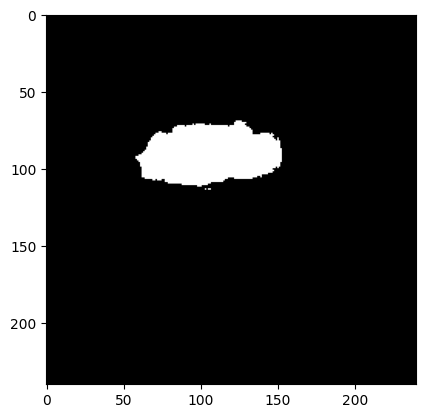

In [ ]:
image_3d = nib.load("/content/ASNR-MICCAI-BraTS2023-SSA-Challenge-ValidationData/BraTS-SSA-00132-000/BraTS-SSA-00132-000-t2f.nii.gz")
image_3d = image_3d.get_fdata()
image = image_3d[:,:,100]
# plt.imshow(image)

lower_bound, upper_bound = np.percentile(image, 0.5), np.percentile(image, 99.5)
image_data_pre = np.clip(image, lower_bound, upper_bound)
d = (np.max(image_data_pre)-np.min(image_data_pre))
d = 1 if d==0 else d
image_data_pre = ((image_data_pre - np.min(image_data_pre))/d) *255.0
image_data_pre[image==0] = 0
image = transform.resize(image_data_pre[:,:], (256, 256), order=3, preserve_range=True, mode='constant', anti_aliasing=True)
image = np.uint8(image)
image = np.stack((image, image, image), axis = -1 )

bbox = get_yolo_box(image)

mask = get_sam_masks(image, bbox)
print(mask.shape)
print(np.unique(mask))

plt.imshow(mask, cmap = "gray")



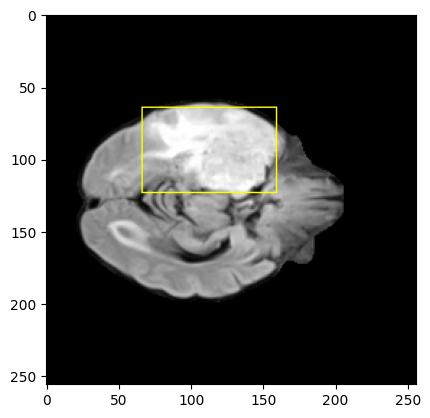

In [ ]:
colour = (255, 255, 0)
thickness = 1
rectangle_img = cv2.rectangle(image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), colour, thickness)
plt.imshow(rectangle_img, cmap="gray")

In [ ]:
src_folder = "/content/ASNR-MICCAI-BraTS2023-SSA-Challenge-ValidationData/"

for i in os.listdir(src_folder):
  image_3d = nib.load(src_folder + i + "/" + i + "-t2f.nii.gz")
  image_3d = image_3d.get_fdata()
  num_slics = image_3d.shape[2]

  output = np.zeros_like(image_3d)

  for s in range(num_slics):
    image = image_3d[:,:,s]

    lower_bound, upper_bound = np.percentile(image, 0.5), np.percentile(image, 99.5)
    image_data_pre = np.clip(image, lower_bound, upper_bound)
    d = (np.max(image_data_pre)-np.min(image_data_pre))
    d = 1 if d==0 else d
    image_data_pre = ((image_data_pre - np.min(image_data_pre))/d) *255.0
    image_data_pre[image==0] = 0
    image = transform.resize(image_data_pre[:,:], (256, 256), order=3, preserve_range=True, mode='constant', anti_aliasing=True)
    image = np.uint8(image)
    image = np.stack((image, image, image), axis = -1 )

    bbox = get_yolo_box(image)

    mask = get_sam_masks(image, bbox)

    output[:,:,s] = mask

  id = i.split("-")[2]
  time = i.split("-")[3]
  ni_img = nib.Nifti1Image(output, affine=np.eye(4))
  nib.save(ni_img, "/content/out/seg-" + id + "-" + time + ".nii.gz" )
  print("-------------------case done ", np.unique(output), "-----------------------")





In [ ]:
! zip -r submission_1.zip "/content/out"

## YOLO + SAM binary + voting

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install ultralytics

In [ ]:
import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/Noha-Magdy/segment-anything.git'

!mkdir images
!wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
!wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/groceries.jpg

!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth


In [ ]:
! pip install monai
! pip install pytorch-lightning


In [ ]:
import os
import torch
import numpy as np
import cv2
from tqdm import tqdm
import nibabel as nib
import matplotlib.image
import random
from ultralytics import YOLO
import matplotlib.pyplot as plt


from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision.transforms import Compose, ToTensor, Resize
from torch.utils.data import Subset

from segment_anything import SamPredictor, sam_model_registry
from segment_anything.utils.transforms import ResizeLongestSide
import torch.nn.functional as F
from skimage import transform, io, segmentation


from monai.networks.nets import UNet

import monai

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint



In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
! unzip "/content/drive/MyDrive/Updated_BraTSData_SSA_only.zip"

In [ ]:
! unzip "ASNR-MICCAI-BraTS2023-SSA-Challenge-ValidationData.zip"

In [ ]:
len(os.listdir("/content/ASNR-MICCAI-BraTS2023-SSA-Challenge-ValidationData"))

15

In [ ]:
# models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


yolo = YOLO('/content/drive/MyDrive/save_to/yolo/t2f_z_2/weights/best.pt')


model_type = 'vit_h'
checkpoint = 'sam_vit_h_4b8939.pth'
sam_model = sam_model_registry[model_type](checkpoint=checkpoint).to(device)

decoder = sam_model.mask_decoder
model_path = "/content/sam_model_best_more_epochs.pth"
checkpoint = torch.load(model_path, map_location="cpu")
decoder.load_state_dict(checkpoint)
decoder.to(device)


In [ ]:
def get_yolo_box(image):
  results = yolo.predict(image, stream = False)
  boxes = results[0].boxes

  if len(boxes.xyxy.cpu().numpy()) == 0:
    return [0,0,0,0]

  box = boxes.xyxy[0].cpu().numpy()
  box = [int(i) for i in box]

  return box


def get_bounding_box(mask):

  y_indices, x_indices = np.where(mask > 0)
  if len(y_indices) == 0:
    return [0,0,0,0]
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = mask.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  # bboxes = np.array([x_min, y_min, x_max, y_max])

  return [x_min, y_min, x_max, y_max]


def get_3d_from_SAM(_3d_image, sam_model, decoder ,device, flair):
  sam_model.to(device)

  output = np.zeros_like(_3d_image)

  # m = nib.load("/content/ASNR-MICCAI-BraTS2023-SSA-Challenge-TrainingData_V2/BraTS-SSA-00122-000/BraTS-SSA-00122-000-seg.nii.gz")
  # m = m.get_fdata()

  sclices = _3d_image.shape[2]
  for s in range(sclices):
    image = _3d_image[:,:,s]


    image = np.stack((image, image, image), axis = -1 )
    image = np.uint8(image) #sure?

    sam_transform = ResizeLongestSide(sam_model.image_encoder.img_size)
    image = sam_transform.apply_image(image)
    # resized_shapes.append(resize_img.shape[:2])
    image = torch.as_tensor(image.transpose(2, 0, 1)).to('cuda')
    # model input: (1, 3, 1024, 1024)
    image = sam_model.preprocess(image[None,:,:,:]) # (1, 3, 1024, 1024)
    image = image[0,...] # (3, 1024, 1024)


    t = flair[:,:,s]
    # t = transform.resize(t[:,:], (256, 256), order=3, preserve_range=True, mode='constant', anti_aliasing=True)
    t = np.stack((t, t, t), axis = -1 )
    t = np.uint8(t)
    bbox = get_yolo_box(t)
    # mask= m[:,:,s]
    # bbox = get_bounding_box(mask)


    if bbox == [0,0,0,0]:
      masks = np.zeros((240,240))
    else:
      box_np = np.array(bbox)
      sam_trans = ResizeLongestSide(sam_model.image_encoder.img_size)
      box = sam_trans.apply_boxes(box_np, (256, 256))
      box_torch = torch.as_tensor(box, dtype=torch.float)

      with torch.no_grad():
        sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(points=None, boxes=box_torch.to(device), masks=None)

      with torch.no_grad():
        emb = sam_model.image_encoder(image[None,...].to(device))[0]

      with torch.no_grad():
        mask_predictions, _ = decoder(
              image_embeddings= emb[None,...].to(device), # (B, 256, 64, 64)
              image_pe=sam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
              sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
              dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
              multimask_output=False,
            )

      masks = sam_model.postprocess_masks(mask_predictions, (1024, 1024), (240, 240))
      masks = masks > sam_model.mask_threshold
      masks = np.squeeze(masks.cpu().numpy(), axis = 0)
      masks = np.int32(masks)
      masks = np.squeeze(masks, axis = 0)

    output[:,:,s] = masks


  return output


In [ ]:
image_3d = nib.load("/content/ASNR-MICCAI-BraTS2023-SSA-Challenge-TrainingData_V2/BraTS-SSA-00122-000/BraTS-SSA-00122-000-t2f.nii.gz")
image_3d = image_3d.get_fdata()
lower_bound, upper_bound = np.percentile(image_3d, 0.5), np.percentile(image_3d, 99.5)
image_data_pre = np.clip(image_3d, lower_bound, upper_bound)
d = (np.max(image_data_pre)-np.min(image_data_pre))
d = 1 if d==0 else d
image_data_pre = ((image_data_pre - np.min(image_data_pre))/d)*255
image_data_pre[image_3d==0] = 0
image_3d = image_data_pre

mask = get_3d_from_SAM(image_3d, sam_model, decoder,device, image_3d)



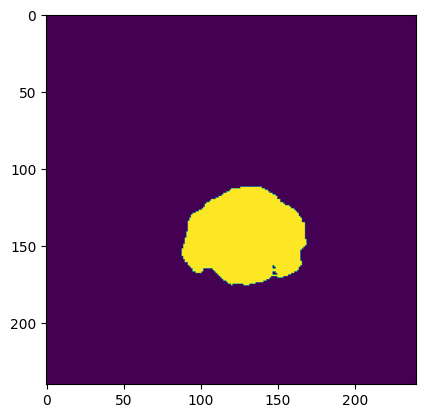

In [ ]:
plt.imshow(mask[:,:,90])

array([          0,           1], dtype=float32)

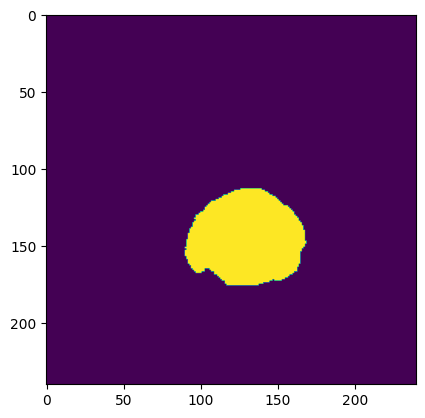

In [ ]:
im = np.load("/content/drive/MyDrive/voting_data/input/BraTS-SSA-00122-000.npy")

flair = im[6,:,:,90]
plt.imshow(flair)
np.unique(flair)

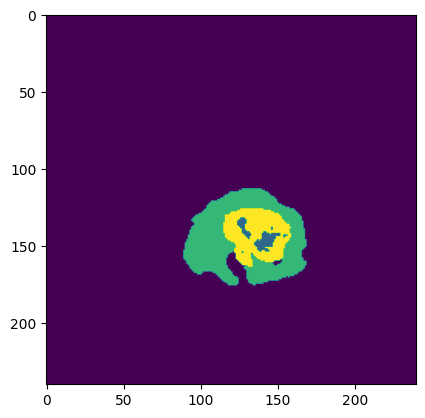

In [ ]:
image_3d = nib.load("/content/ASNR-MICCAI-BraTS2023-SSA-Challenge-TrainingData_V2/BraTS-SSA-00122-000/BraTS-SSA-00122-000-seg.nii.gz")
image_3d = image_3d.get_fdata()
image = image_3d[:,:,90]
plt.imshow(image)


In [ ]:
net = UNet(
    spatial_dims=3,
    in_channels=8,
    out_channels=3,
    channels=(64, 128, 256, 512),
    strides=(2, 2, 3),
).to(device)


loss_function = monai.losses.DiceLoss(sigmoid=True, to_onehot_y = False).to(device)
optimizer = torch.optim.Adam(net.parameters(), 0.001)

def configure_optimizers():
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=4)
    return [optimizer], [scheduler]


class Model(pl.LightningModule):
    def __init__(self, net, criterion, learning_rate, optimizer_class):
        super().__init__()
        self.lr = learning_rate
        self.net = net
        self.criterion = criterion
        self.optimizer_class = optimizer_class

    def forward(self, input_):
      return self.net(input_)

    def configure_optimizers(self):
        optimizer = self.optimizer_class(self.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=4, verbose=True)
        # return [optimizer], [scheduler]
        return {"optimizer": optimizer,
                "lr_scheduler": scheduler,
                "monitor": "val_loss"}

    def prepare_batch(self, batch):
        return (batch["input"], batch["mask"])



    def infer_batch(self, batch):
        x, y = self.prepare_batch(batch)
        y_hat = self.net(x)
        return y_hat, y

    def training_step(self, batch, batch_idx):
        y_hat, y = self.infer_batch(batch)
        loss = self.criterion(y_hat, y)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        y_hat, y = self.infer_batch(batch)
        loss = self.criterion(y_hat, y)
        self.log("val_loss", loss)
        return loss

PATH = "/content/drive/MyDrive/miccai_data/voting_unet_small-v25.ckpt"
model = Model.load_from_checkpoint(PATH,
                                   net=net,
                                   criterion=loss_function,
                                   learning_rate=0.001,
                                   optimizer_class=torch.optim.Adam
                                   )

model = model.to(device)


In [ ]:
src_folder = "/content/ASNR-MICCAI-BraTS2023-SSA-Challenge-ValidationData/"
data = os.listdir(src_folder)
for i in tqdm(data):
  t2f =  nib.load(src_folder + i + "/" + i +"-t2f.nii.gz")
  t2f = t2f.get_fdata()
  lower_bound, upper_bound = np.percentile(t2f, 0.5), np.percentile(t2f, 99.5)
  image_data_pre = np.clip(t2f, lower_bound, upper_bound)
  d = (np.max(image_data_pre)-np.min(image_data_pre))
  d = 1 if d==0 else d
  image_data_pre = ((image_data_pre - np.min(image_data_pre))/d)
  image_data_pre[t2f==0] = 0
  t2f = image_data_pre


  t1n =  nib.load(src_folder + i + "/" + i + "-t1n.nii.gz")
  t1n = t1n.get_fdata()
  lower_bound, upper_bound = np.percentile(t1n, 0.5), np.percentile(t1n, 99.5)
  image_data_pre = np.clip(t1n, lower_bound, upper_bound)
  d = (np.max(image_data_pre)-np.min(image_data_pre))
  d = 1 if d==0 else d
  image_data_pre = ((image_data_pre - np.min(image_data_pre))/d)
  image_data_pre[t1n==0] = 0
  t1n = image_data_pre


  t2w =  nib.load(src_folder + i + "/" + i + "-t2w.nii.gz")
  t2w = t2w.get_fdata()
  lower_bound, upper_bound = np.percentile(t2w, 0.5), np.percentile(t2w, 99.5)
  image_data_pre = np.clip(t2w, lower_bound, upper_bound)
  d = (np.max(image_data_pre)-np.min(image_data_pre))
  d = 1 if d==0 else d
  image_data_pre = ((image_data_pre - np.min(image_data_pre))/d)
  image_data_pre[t2w==0] = 0
  t2w = image_data_pre


  t1c =  nib.load(src_folder + i + "/" + i + "-t1c.nii.gz")
  t1c = t1c.get_fdata()
  lower_bound, upper_bound = np.percentile(t1c, 0.5), np.percentile(t1c, 99.5)
  image_data_pre = np.clip(t1c, lower_bound, upper_bound)
  d = (np.max(image_data_pre)-np.min(image_data_pre))
  d = 1 if d==0 else d
  image_data_pre = ((image_data_pre - np.min(image_data_pre))/d)
  image_data_pre[t1c==0] = 0
  t1c = image_data_pre


  sam_flair = get_3d_from_SAM(t2f, sam_model, decoder, device, t2f*255.)
  sam_t1 = get_3d_from_SAM(t1n, sam_model, decoder,device, t2f*255.)
  sam_t2 = get_3d_from_SAM(t2w, sam_model, decoder,device, t2f*255.)
  sam_t1c = get_3d_from_SAM(t1c, sam_model, decoder,device, t2f*255.)



  input_ = np.stack(( t2f, t1n, t2w, t1c, sam_t1, sam_t2, sam_flair, sam_t1c), axis = 0)
  input_ = np.float32(input_) #why
  input_ = np.expand_dims(input_, axis = 0)
  input_ = torch.as_tensor(input_, dtype=torch.float ).to(device)


  with torch.no_grad():
    out_mask = model.net(input_)

  m = out_mask
  m =torch.sigmoid(m).cpu().numpy()

  # thr=0.5
  # m[m>=thr]= 1
  # m[m<thr] = 0
  m = np.squeeze(m, axis = 0)
  print(np.unique(m))
  m = m[:,:,:,:155]

  output = np.zeros(m.shape[1:])

  msk1 = m[0]
  msk1[msk1<0.5]= 0
  msk1[msk1>=0.5]= 1

  msk2 = m[1]
  msk2[msk2>=0.5]= 1
  msk2[msk2<0.5]= 0

  msk3 = m[2]
  msk3[msk3>=0.5]= 1
  msk3[msk3<0.5]= 0


  output[msk2>0] = 2
  output[msk3>0] = 3
  output[msk1>0] = 1

  print(np.unique(output))

  id = i.split("-")[2]
  time = i.split("-")[3]
  ni_img = nib.Nifti1Image(output, affine=np.eye(4))
  nib.save(ni_img, "/content/out/seg-" + id + "-" + time + ".nii.gz" )
  print("-------------------case done ", np.unique(output), "-----------------------")





  0%|          | 0/15 [00:00<?, ?it/s]
0: 256x256 (no detections), 6.4ms
Speed: 25.5ms preprocess, 6.4ms inference, 93.8ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 6.3ms
Speed: 1.6ms preprocess, 6.3ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 6.3ms
Speed: 1.7ms preprocess, 6.3ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 6.5ms
Speed: 1.6ms preprocess, 6.5ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 6.4ms
Speed: 1

[ 9.6649e-39   2.773e-37  2.8301e-37 ...     0.99471       0.996     0.99701]
[          0           2]


  7%|▋         | 1/15 [00:30<07:03, 30.23s/it]

-------------------case done  [          0           2] -----------------------



0: 256x256 (no detections), 6.9ms
Speed: 1.3ms preprocess, 6.9ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 6.3ms
Speed: 1.1ms preprocess, 6.3ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 6.8ms
Speed: 1.2ms preprocess, 6.8ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 6.7ms
Speed: 1.1ms preprocess, 6.7ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 6.5ms
Speed: 1.1ms preprocess, 6.5ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 7.0ms
Speed: 1.2ms preprocess, 7.0ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 6.6ms
Speed: 1.2ms preprocess, 6.6ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 7.0ms
Speed: 1.1ms preprocess, 7.0ms inference, 0.7ms 

[          0  5.7566e-39  1.1167e-38 ...           1           1           1]
[          0           1           2           3]


 13%|█▎        | 2/15 [02:07<15:02, 69.39s/it]

-------------------case done  [          0           1           2           3] -----------------------



0: 256x256 (no detections), 8.4ms
Speed: 1.4ms preprocess, 8.4ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 7.0ms
Speed: 1.1ms preprocess, 7.0ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 6.2ms
Speed: 1.1ms preprocess, 6.2ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 6.4ms
Speed: 1.2ms preprocess, 6.4ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 6.4ms
Speed: 1.3ms preprocess, 6.4ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 7.1ms
Speed: 1.1ms preprocess, 7.1ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 7.1ms
Speed: 1.1ms preprocess, 7.1ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 6.4ms
Speed: 1.1ms preprocess, 6.4ms inference, 0.7ms 

[          0  6.7888e-39  8.2115e-39 ...     0.12437     0.12968     0.33741]
[          0]


 20%|██        | 3/15 [02:35<10:06, 50.58s/it]

-------------------case done  [          0] -----------------------



0: 256x256 (no detections), 6.7ms
Speed: 1.2ms preprocess, 6.7ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 7.7ms
Speed: 1.1ms preprocess, 7.7ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 6.3ms
Speed: 1.1ms preprocess, 6.3ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 6.5ms
Speed: 1.1ms preprocess, 6.5ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 6.4ms
Speed: 1.2ms preprocess, 6.4ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 6.8ms
Speed: 1.2ms preprocess, 6.8ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 6.3ms
Speed: 1.2ms preprocess, 6.3ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 6.3ms
Speed: 1.1ms preprocess, 6.3ms inference, 0.7ms 

[ 3.1247e-36  7.8509e-36  9.8158e-36 ...           1           1           1]
[          0           1           2           3]


 27%|██▋       | 4/15 [03:31<09:41, 52.89s/it]

-------------------case done  [          0           1           2           3] -----------------------



0: 256x256 (no detections), 7.2ms
Speed: 1.4ms preprocess, 7.2ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 6.8ms
Speed: 1.2ms preprocess, 6.8ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 7.0ms
Speed: 1.4ms preprocess, 7.0ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 6.5ms
Speed: 1.3ms preprocess, 6.5ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 6.5ms
Speed: 1.4ms preprocess, 6.5ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 7.0ms
Speed: 1.5ms preprocess, 7.0ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 8.9ms
Speed: 1.3ms preprocess, 8.9ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 6.7ms
Speed: 1.2ms preprocess, 6.7ms inference, 0.7ms 

[ 8.6403e-32  1.3568e-31   2.233e-31 ...           1           1           1]
[          0           1           2           3]


 33%|███▎      | 5/15 [06:01<14:38, 87.86s/it]

-------------------case done  [          0           1           2           3] -----------------------



0: 256x256 (no detections), 7.1ms
Speed: 1.3ms preprocess, 7.1ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 6.4ms
Speed: 1.2ms preprocess, 6.4ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 6.5ms
Speed: 1.3ms preprocess, 6.5ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 6.5ms
Speed: 1.3ms preprocess, 6.5ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 6.5ms
Speed: 1.3ms preprocess, 6.5ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 6.6ms
Speed: 1.3ms preprocess, 6.6ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 6.6ms
Speed: 1.2ms preprocess, 6.6ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 6.6ms
Speed: 1.3ms preprocess, 6.6ms inference, 0.7ms 

[ 3.9542e-36  1.1817e-35  2.1898e-35 ...           1           1           1]
[          0           1           2           3]


 40%|████      | 6/15 [07:54<14:27, 96.38s/it]

-------------------case done  [          0           1           2           3] -----------------------



0: 256x256 (no detections), 7.2ms
Speed: 1.6ms preprocess, 7.2ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 6.3ms
Speed: 1.5ms preprocess, 6.3ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 6.3ms
Speed: 1.5ms preprocess, 6.3ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 6.3ms
Speed: 1.5ms preprocess, 6.3ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 6.4ms
Speed: 1.5ms preprocess, 6.4ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 6.4ms
Speed: 1.5ms preprocess, 6.4ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 6.8ms
Speed: 1.5ms preprocess, 6.8ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 6.4ms
Speed: 1.5ms preprocess, 6.4ms inference, 0.7ms 

[ 3.3079e-33  3.9711e-33  7.0707e-33 ...           1           1           1]
[          0           1           2           3]


 47%|████▋     | 7/15 [09:50<13:43, 102.92s/it]

-------------------case done  [          0           1           2           3] -----------------------



0: 256x256 (no detections), 7.2ms
Speed: 1.3ms preprocess, 7.2ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 8.3ms
Speed: 1.2ms preprocess, 8.3ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 8.4ms
Speed: 1.3ms preprocess, 8.4ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 6.4ms
Speed: 1.2ms preprocess, 6.4ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 8.2ms
Speed: 1.2ms preprocess, 8.2ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 6.3ms
Speed: 1.2ms preprocess, 6.3ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 6.6ms
Speed: 1.3ms preprocess, 6.6ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 6.7ms
Speed: 1.3ms preprocess, 6.7ms inference, 0.7ms 

[ 1.3997e-36  1.0051e-35  1.8708e-35 ...           1           1           1]
[          0           1           2           3]


 53%|█████▎    | 8/15 [11:56<12:50, 110.09s/it]

-------------------case done  [          0           1           2           3] -----------------------



0: 256x256 (no detections), 7.2ms
Speed: 1.9ms preprocess, 7.2ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 7.6ms
Speed: 1.8ms preprocess, 7.6ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 6.5ms
Speed: 1.7ms preprocess, 6.5ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 6.5ms
Speed: 1.6ms preprocess, 6.5ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 6.3ms
Speed: 1.7ms preprocess, 6.3ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 6.4ms
Speed: 1.7ms preprocess, 6.4ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 6.5ms
Speed: 1.7ms preprocess, 6.5ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 6.5ms
Speed: 1.6ms preprocess, 6.5ms inference, 0.7ms 

[ 4.4214e-32  8.0995e-32  1.2359e-31 ...           1           1           1]
[          0           2           3]


 60%|██████    | 9/15 [13:59<11:26, 114.34s/it]

-------------------case done  [          0           2           3] -----------------------



0: 256x256 (no detections), 7.0ms
Speed: 1.3ms preprocess, 7.0ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 6.3ms
Speed: 1.1ms preprocess, 6.3ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 6.4ms
Speed: 1.2ms preprocess, 6.4ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 6.3ms
Speed: 1.1ms preprocess, 6.3ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 6.4ms
Speed: 1.2ms preprocess, 6.4ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 6.5ms
Speed: 1.2ms preprocess, 6.5ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 6.5ms
Speed: 1.2ms preprocess, 6.5ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 8.2ms
Speed: 1.2ms preprocess, 8.2ms inference, 0.9ms 

[  7.787e-30  1.6951e-29  1.7815e-29 ...           1           1           1]
[          0           1           2           3]


 67%|██████▋   | 10/15 [15:10<08:24, 100.86s/it]

-------------------case done  [          0           1           2           3] -----------------------



0: 256x256 (no detections), 7.8ms
Speed: 1.4ms preprocess, 7.8ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 6.5ms
Speed: 1.3ms preprocess, 6.5ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 6.5ms
Speed: 1.2ms preprocess, 6.5ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 7.1ms
Speed: 1.6ms preprocess, 7.1ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 6.6ms
Speed: 1.5ms preprocess, 6.6ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 6.6ms
Speed: 1.6ms preprocess, 6.6ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 6.9ms
Speed: 1.6ms preprocess, 6.9ms inference, 0.7ms 

[ 1.1936e-33  1.3378e-33  1.8958e-33 ...           1           1           1]
[          0           1           2           3]


 73%|███████▎  | 11/15 [16:48<06:39, 99.81s/it] 

-------------------case done  [          0           1           2           3] -----------------------



0: 256x256 (no detections), 6.7ms
Speed: 1.3ms preprocess, 6.7ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 6.5ms
Speed: 1.3ms preprocess, 6.5ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 6.8ms
Speed: 1.6ms preprocess, 6.8ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 6.7ms
Speed: 1.2ms preprocess, 6.7ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 6.4ms
Speed: 1.2ms preprocess, 6.4ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 7.5ms
Speed: 1.8ms preprocess, 7.5ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 6.8ms
Speed: 1.2ms preprocess, 6.8ms inference, 0.7ms 

[ 1.7829e-29  2.2446e-29  4.3548e-29 ...           1           1           1]
[          0           1           2           3]


 80%|████████  | 12/15 [19:09<05:37, 112.53s/it]

-------------------case done  [          0           1           2           3] -----------------------



0: 256x256 (no detections), 7.1ms
Speed: 1.6ms preprocess, 7.1ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 7.1ms
Speed: 1.6ms preprocess, 7.1ms inference, 0.7ms 

[ 4.5029e-32  1.3593e-31  3.1725e-31 ...           1           1           1]
[          0           1           2           3]


 87%|████████▋ | 13/15 [21:27<04:00, 120.20s/it]

-------------------case done  [          0           1           2           3] -----------------------



0: 256x256 (no detections), 7.0ms
Speed: 1.5ms preprocess, 7.0ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 6.7ms
Speed: 1.2ms preprocess, 6.7ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 6.6ms
Speed: 1.3ms preprocess, 6.6ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 6.5ms
Speed: 1.4ms preprocess, 6.5ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 7.6ms
Speed: 1.9ms preprocess, 7.6ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 6.8ms
Speed: 1.2ms preprocess, 6.8ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 6.5ms
Speed: 1.2ms preprocess, 6.5ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 8.4ms
Speed: 1.9ms preprocess, 8.4ms inference, 0.9ms 

[ 7.5168e-33  1.2348e-32  1.4168e-32 ...           1           1           1]
[          0           1           2           3]


 93%|█████████▎| 14/15 [22:58<01:51, 111.25s/it]

-------------------case done  [          0           1           2           3] -----------------------



0: 256x256 (no detections), 9.1ms
Speed: 1.7ms preprocess, 9.1ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 6.3ms
Speed: 1.2ms preprocess, 6.3ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 6.5ms
Speed: 1.4ms preprocess, 6.5ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 6.4ms
Speed: 1.4ms preprocess, 6.4ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 6.9ms
Speed: 1.4ms preprocess, 6.9ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 6.8ms
Speed: 1.4ms preprocess, 6.8ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 8.2ms
Speed: 1.8ms preprocess, 8.2ms inference, 0.9ms 

[ 1.1879e-38  1.2609e-38  1.5343e-38 ...           1           1           1]
[          0           2           3]


100%|██████████| 15/15 [23:58<00:00, 95.91s/it]

-------------------case done  [          0           2           3] -----------------------


In [ ]:
! zip -r submission.zip "/content/out"

  adding: content/out/ (stored 0%)
  adding: content/out/seg-00192-000.nii.gz (deflated 91%)
  adding: content/out/seg-00210-000.nii.gz (deflated 77%)
  adding: content/out/seg-00158-000.nii.gz (deflated 95%)
  adding: content/out/seg-00129-000.nii.gz (deflated 100%)
  adding: content/out/seg-00148-000.nii.gz (deflated 72%)
  adding: content/out/seg-00227-000.nii.gz (deflated 99%)
  adding: content/out/seg-00143-000.nii.gz (deflated 72%)
  adding: content/out/seg-00218-000.nii.gz (deflated 96%)
  adding: content/out/seg-00132-000.nii.gz (deflated 67%)
  adding: content/out/seg-00126-000.nii.gz (deflated 84%)
  adding: content/out/seg-00188-000.nii.gz (deflated 94%)
  adding: content/out/seg-00180-000.nii.gz (deflated 98%)
  adding: content/out/seg-00198-000.nii.gz (deflated 69%)
  adding: content/out/seg-00139-000.nii.gz (deflated 80%)
  adding: content/out/seg-00169-000.nii.gz (deflated 73%)


In [ ]:
s = np.zeros((1,7, 240, 240, 155), dtype= np.float32)
s = torch.from_numpy(s).to("cuda")
with torch.no_grad():
  out_mask = model.net(s)
out_mask = np.squeeze(out_mask, axis = 0)
out_mask = out_mask[:,:,:,:155].cpu().numpy()
out_mask.shape

(3, 240, 240, 155)

In [ ]:
temp = out_mask
out_mask = out_mask > sam_model.mask_threshold
out_mask = np.squeeze(out_mask.cpu().numpy(), axis = 0)
out_mask = np.int32(out_mask)
out_mask = out_mask[:,:,:,:155]

output = np.zeros(out_mask.shape[1:])

msk1 = out_mask[0]
# msk1[msk1>0.5]= 1
msk2 = out_mask[1]
# msk2[msk2>0.5]= 1
msk3 = out_mask[2]
# msk3[msk3>0.5]= 1

output[msk1>0] = 1
output[msk2>0] = 2
output[msk3>0] = 3




In [ ]:
! rm -r "out"

[          0           1]
[          0           1           2           3]


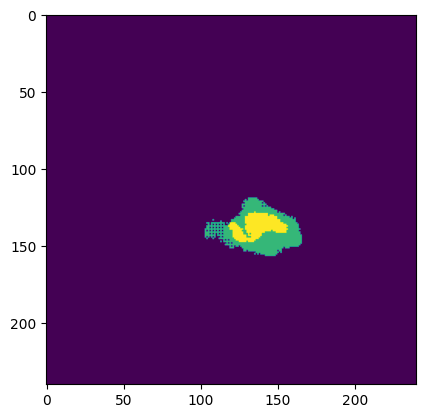

In [ ]:
m = out_mask

m =torch.sigmoid(m).cpu().numpy()

# lower_bound, upper_bound = np.percentile(m, 0.5), np.percentile(m, 99.5)
# image_data_pre = np.clip(m, lower_bound, upper_bound)
# d = (np.max(image_data_pre)-np.min(image_data_pre))
# d = 1 if d==0 else d
# image_data_pre = ((image_data_pre - np.min(image_data_pre))/d)
# image_data_pre[m==0] = 0
# m = image_data_pre

thr=0.5
m[m>=thr]= 1
m[m<thr] = 0
# m = 1-m
m = np.squeeze(m, axis = 0)
# m = np.int32(m)
print(np.unique(m))
m = m[:,:,:,:155]

output = np.zeros(m.shape[1:])

msk1 = m[0]
# msk1[msk1>0.5]= 1
msk2 = m[1]
# msk2[msk2>0.5]= 1
msk3 = m[2]
# msk3[msk3>0.5]= 1

output[msk2>0] = 2
output[msk1>0] = 1
output[msk3>0] = 3


print(np.unique(output))


plt.imshow(output[:,:,90])

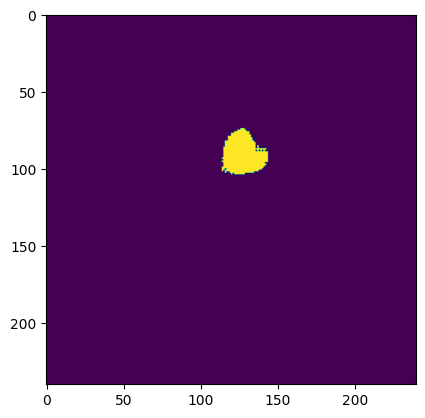

In [ ]:
image_3d_t1 = nib.load("/content/out/seg-00132-000.nii.gz")
image_3d_t1 = image_3d_t1.get_fdata()
plt.imshow(image_3d_t1[:,:,110])

In [ ]:
output.shape

(240, 240, 155)

## 2D UNet

In [ ]:
! pip install monai
! pip install pytorch-lightning

In [2]:
import os
import torch
import numpy as np
import cv2
from tqdm import tqdm
import nibabel as nib
import matplotlib.image
import random


from monai.networks.nets import UNet
from torchsummary import summary
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision.transforms import ToTensor, Resize
from torch.utils.data import Subset
import monai
import torch.nn.functional as F
from skimage import transform, io, segmentation
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! unzip "/content/drive/MyDrive/Updated_BraTSData_SSA_only.zip"

In [ ]:
! unzip "ASNR-MICCAI-BraTS2023-SSA-Challenge-ValidationData.zip"

In [7]:
device = "cuda"
net = UNet(
    spatial_dims=2,
    in_channels=4,
    out_channels=3,
    channels=(16, 32, 128, 256),
    strides=(2, 2, 3),
    # num_res_units=5
).to(device)


loss_function = monai.losses.DiceLoss(sigmoid=True, to_onehot_y = False).to(device)
optimizer = torch.optim.Adam(net.parameters(), 0.001)

def configure_optimizers():
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=4)
    return [optimizer], [scheduler]


class Model(pl.LightningModule):
    def __init__(self, net, criterion, learning_rate, optimizer_class):
        super().__init__()
        self.lr = learning_rate
        self.net = net
        self.criterion = criterion
        self.optimizer_class = optimizer_class

    def forward(self, input_):
      return self.net(input_)

    def configure_optimizers(self):
        optimizer = self.optimizer_class(self.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=4, verbose=True)
        # return [optimizer], [scheduler]
        return {"optimizer": optimizer,
                "lr_scheduler": scheduler,
                "monitor": "val_loss"}

    def prepare_batch(self, batch):
        return (batch["input"], batch["mask"])



    def infer_batch(self, batch):
        x, y = self.prepare_batch(batch)
        y_hat = self.net(x)
        return y_hat, y

    def training_step(self, batch, batch_idx):
        y_hat, y = self.infer_batch(batch)
        loss = self.criterion(y_hat, y)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        y_hat, y = self.infer_batch(batch)
        loss = self.criterion(y_hat, y)
        self.log("val_loss", loss)
        return loss

PATH = "/content/drive/MyDrive/miccai_data/unet_2d-v1.ckpt"
model = Model.load_from_checkpoint(PATH,
                                   net=net,
                                   criterion=loss_function,
                                   learning_rate=0.001,
                                   optimizer_class=torch.optim.Adam
                                   )

model = model.to(device)


In [12]:
ground_truth_path = "/content/ASNR-MICCAI-BraTS2023-SSA-Challenge-ValidationData"
data = os.listdir(ground_truth_path)
for i in tqdm(data):
  output = np.zeros((240,240,155))
  for s in range(155):
    t1c =  nib.load(ground_truth_path + "/" + i + "/"+ i +"-t1c.nii.gz")
    t1c = t1c.get_fdata()
    lower_bound, upper_bound = np.percentile(t1c, 0.5), np.percentile(t1c, 99.5)
    image_data_pre = np.clip(t1c, lower_bound, upper_bound)
    d = (np.max(image_data_pre)-np.min(image_data_pre))
    d = 1 if d==0 else d
    image_data_pre = ((image_data_pre - np.min(image_data_pre))/d)
    image_data_pre[t1c==0] = 0
    t1c = image_data_pre
    t1c = t1c[:,:,s]

    t1n =  nib.load(ground_truth_path + "/" + i + "/"+ i +"-t1n.nii.gz")
    t1n = t1n.get_fdata()
    lower_bound, upper_bound = np.percentile(t1n, 0.5), np.percentile(t1n, 99.5)
    image_data_pre = np.clip(t1n, lower_bound, upper_bound)
    d = (np.max(image_data_pre)-np.min(image_data_pre))
    d = 1 if d==0 else d
    image_data_pre = ((image_data_pre - np.min(image_data_pre))/d)
    image_data_pre[t1n==0] = 0
    t1n = image_data_pre
    t1n = t1n[:,:,s]

    t2f =  nib.load(ground_truth_path + "/" + i + "/"+ i +"-t2f.nii.gz")
    t2f = t2f.get_fdata()
    lower_bound, upper_bound = np.percentile(t2f, 0.5), np.percentile(t2f, 99.5)
    image_data_pre = np.clip(t2f, lower_bound, upper_bound)
    d = (np.max(image_data_pre)-np.min(image_data_pre))
    d = 1 if d==0 else d
    image_data_pre = ((image_data_pre - np.min(image_data_pre))/d)
    image_data_pre[t2f==0] = 0
    t2f = image_data_pre
    t2f = t2f[:,:,s]

    t2w =  nib.load(ground_truth_path + "/" + i + "/"+ i +"-t2w.nii.gz")
    t2w = t2w.get_fdata()
    lower_bound, upper_bound = np.percentile(t2w, 0.5), np.percentile(t2w, 99.5)
    image_data_pre = np.clip(t2w, lower_bound, upper_bound)
    d = (np.max(image_data_pre)-np.min(image_data_pre))
    d = 1 if d==0 else d
    image_data_pre = ((image_data_pre - np.min(image_data_pre))/d)
    image_data_pre[t2w==0] = 0
    t2w = image_data_pre
    t2w = t2w[:,:,s]

    input_ = np.stack((t1c, t1n, t2f, t2w), axis = 0)
    input_ = np.expand_dims(input_, axis =0)
    input_ = torch.as_tensor(input_, dtype = torch.float).to(device)
    with torch.no_grad():
      out_mask = model.net(input_)

    m = out_mask
    m =torch.sigmoid(m).cpu().numpy()
    m = np.squeeze(m, axis = 0)


    temp_out = np.zeros((240,240))

    msk1 = m[0]
    msk1[msk1<0.5]= 0
    msk1[msk1>=0.5]= 1

    msk2 = m[1]
    msk2[msk2>=0.5]= 1
    msk2[msk2<0.5]= 0

    msk3 = m[2]
    msk3[msk3>=0.5]= 1
    msk3[msk3<0.5]= 0


    temp_out[msk2>0] = 2
    temp_out[msk3>0] = 3
    temp_out[msk1>0] = 1

  output[:,:,s] = temp_out
  print(np.unique(output))

  id = i.split("-")[2]
  time = i.split("-")[3]
  ni_img = nib.Nifti1Image(output, affine=np.eye(4))
  nib.save(ni_img, "/content/out/seg-" + id + "-" + time + ".nii.gz" )
  print("-------------------case done ", np.unique(output), "-----------------------")



  0%|          | 0/15 [00:00<?, ?it/s]

[0.]


  7%|▋         | 1/15 [05:41<1:19:43, 341.65s/it]

-------------------case done  [0.] -----------------------
[0. 1. 2. 3.]


 13%|█▎        | 2/15 [11:21<1:13:44, 340.32s/it]

-------------------case done  [0. 1. 2. 3.] -----------------------
[0.]


 20%|██        | 3/15 [17:00<1:07:57, 339.77s/it]

-------------------case done  [0.] -----------------------
[0.]


 27%|██▋       | 4/15 [22:39<1:02:15, 339.58s/it]

-------------------case done  [0.] -----------------------


 27%|██▋       | 4/15 [26:17<1:12:18, 394.44s/it]


KeyboardInterrupt: ignored